### 1 - **Install and import necessary packages**

In [1]:
!pip install pyfits

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Created wheel for pyfits: filename=pyfits-3.5-cp37-cp37m-linux_x86_64.whl size=482481 sha256=5898d370a809c32dedebbb30677dbcaf45fb3f583551d36d49cbc6b93f1f0064
  Stored in directory: /root/.cache/pip/wheels/08/e8/5b/05e3ed8ca223800d18334962514e593713e22452e45362ced9
Successfully built pyfits


In [2]:
import numpy as np
import numpy.random
import random
import math as m
import matplotlib.pyplot as py
import scipy
#from scipy.signal import fftconvolve
import os
import pyfits as pf

/usr/local/lib/python3.7/dist-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pwd
#!ls -hal "/content/drive/My Drive/"
!mkdir "/content/drive/My Drive/Strong_Lens_Simulation" # Creates a directory. Change the directory name & path according to your wish.
                                                        # default name is "Strong_lens_Simulation" where FITS files of the simulated galaxies will be saved

/content


### 2 - **Define necessary lensing functions**

In [9]:
#----------------------------------------------------------------
#The function to calculate the new coordinates after a rotation
#----------------------------------------------------------------

def xy_rotate(x, y, xcen, ycen, phi):
	
	"""x, y: numpy ndarrays with same size
		giving coordinates in the old system
		xcen: old-system x coordinate of the new origin
		ycen: old-system y coordinate of the new origin
		phi: angle c.c.w. in degrees from old x to new x axis"""
	phirad = np.deg2rad(phi)
	xnew = (x - xcen) * np.cos(phirad) + (y - ycen) * np.sin(phirad)
	ynew = (y - ycen) * np.cos(phirad) - (x - xcen) * np.sin(phirad)
	return (xnew,ynew)

In [10]:
#----------------------------------------------------------------
# A two dimensional Sersic profile
#----------------------------------------------------------------

def sersic (x, y, par):
	"""Parameters for Sersic profile
		par[0]: Effective intensity
		par[1]: Effective radius
		par[2]: x-center
		par[3]: y-center
		par[4]: axis ratio
		par[5]: counter clockwise major-axis rotation w.r.t. x-axis
		par[6]: sersic index"""
	
	b = 2.*par[6] - 0.3271
	n = 1./par[6]
	(xnew,ynew) = xy_rotate(x, y, par[2], par[3], par[5])
	r_ell_sq =  ( (xnew**2)*(par[4]**2) + ynew**2 )/np.abs(par[1])
	g = par[0]*np.exp( -b*(r_ell_sq**n - 1.) )
	return g

In [12]:
#----------------------------------------------------------------
# Deflection angle due to Singular Isothermal Ellipsoid lens
#----------------------------------------------------------------

def deflect_SIE (x, y, par):
	
	"""Function to calculate the deflection angle due to Isothermal Ellipsoid lens potential & shear
		x, y: vectors or images of coordinates;
		par: vector of parameters defined as follows:
		par[0]: lens strength, or 'Einstein radius'
		par[1]: axis ratio (default=1.0)
		par[2]: major axis Position Angle in degrees c.c.w. of x axis"""
	
	b = np.abs(par[0])
	q = np.abs(par[1])
	phiq = par[2]
	ss = par[3]
	phis = par[4]
	
	# The case q > 1 :
	if (q > 1.):
		q = 1.0 / q
		phiq = phiq + 90.0
	
	# Go into rotated coordinates of the potential:
	phirad = np.deg2rad(phiq)
	xsie = x*np.cos(phirad) + y*np.sin(phirad)
	ysie = y*np.cos(phirad) - x*np.sin(phirad)

	r = np.sqrt(x**2 + y**2)
	t = np.arctan2(y, x)
	
	f = np.sqrt(1. - q**2.)
	xg1 = np.sqrt(q) *b* np.arcsinh((f/q)*np.cos(t))/f
	yg1 = np.sqrt(q) *b* np.arcsin(f*np.sin(t))/f
	
	#External shear
	phisrad = np.deg2rad(phis)
	xg2 = ss*(x * np.cos(2.0*phisrad) + y * np.sin(2.0*phisrad))
	yg2 = ss*(y * np.cos(2.0*phisrad) + x * np.sin(2.0*phisrad))
	
	xg = xg1  + xg2
	yg = yg1  + yg2
	
	return xg, yg

### 3 - **Simulation grid (KiDS resolution)**

In [13]:
#------X-Y Grid of KiDS------------------------------------------

(nx, ny) = (101, 101) # No. of pixels
(Lx, Ly) = (20, 20)   # Total field of view in arc-sec

grid_resolution = float(Lx) / float(nx)
X = np.linspace(-Lx/2., Lx/2., nx)
Y = np.linspace(-Ly/2., Ly/2., nx)
x, y = np.meshgrid(X, Y, sparse=True)

### 4 - **Caustic curve and source positions**

In [14]:
#------------Caustic curve------------------------------------------------------

def caust_t (phi_src, beta, theta, phi):
	f = np.sqrt(1 - beta**2)
	df = np.sqrt(beta)/f
	r_t_x = theta*(df*np.arccosh(1/beta) - np.sqrt(beta))*np.cos(phi_src)**3
	r_t_y = theta*(df*np.arccos(beta) - 1/np.sqrt(beta))*np.sin(phi_src)**3
	(r_t_xx, r_t_yy) = xy_rotate (r_t_x, r_t_y, 0.0, 0.0, -phi)
	return r_t_xx, r_t_yy

In [15]:
#----------Function to determine source position on the source plane------------

def src (beta, theta, r_eff, phi):
  phi_src = 2*np.pi*np.random.uniform(0, 1)
  
  beta = q_l
  theta = b

  f = np.sqrt(1 - beta**2)
  df = np.sqrt(beta)/f
  r_x = theta*(df*np.arccosh(1/beta) - np.sqrt(beta) + 0.5*r_eff)*np.cos(phi_src)**3
  r_y = theta*(df*np.arccos(beta) - 1/np.sqrt(beta) - 0.5*r_eff)*np.sin(phi_src)**3

  R = np.sqrt(r_x**2 + r_y**2)
  r_src = R*np.sqrt(np.random.uniform(0, 1))
  phi_caustic = np.arctan2 (r_y, r_x)

  r_xx = r_src*np.cos(phi_caustic) 
  r_yy = r_src*np.sin(phi_caustic)

  (xx_src, yy_src) = xy_rotate (r_xx, r_yy, 0.0, 0.0, -phi)

  return (xx_src, yy_src)

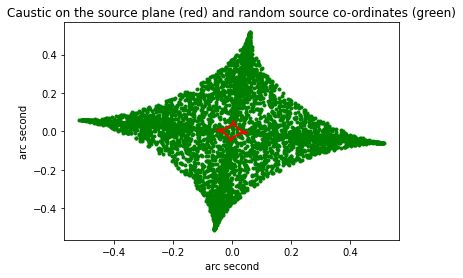

In [16]:
#-------- Let's test the caustic curve for some random parameters---------------

b = 10**(np.random.uniform (np.log10(0.5), np.log10(5.0))) #Einstein Radius
q_l = np.random.uniform(0.3, 0.99) #Axis ratio
phi_l = np.random.uniform(0, 180) #major-minor axis angle
r_eff = 10**(np.random.uniform (np.log10(0.2), np.log10(0.6))) #Effective radius of the main Sersic source


py.figure()
py.plot()
py.title('Caustic on the source plane (red) and random source co-ordinates (green)')
py.xlabel('arc second')
py.ylabel('arc second')

for i in range(5000):
  (x_s, y_s) = src (q_l, b, r_eff, phi_l)
  #print ("Random source co-ordinate (x, y):", x_s, y_s)
  py.plot(x_s, y_s, 'o', markersize=3, color='g')

py.plot(*caust_t(np.linspace(0, 2*np.pi, 200), q_l, b, phi_l), color='r', lw=2 )
py.show()

### 5 - **Generation of Gaussian Random Field**

In [17]:
#--------Power spectrum ------------------------------------------

def powspec(L, variance, Npix, Psum, power):
  if L <= 0:
    P = 0.0
  else:
    A = variance*(Npix**2.)/(2.*Psum)
    P = A*L**(power)
  return P

In [18]:
def Psum_calculator (nx, ny, Lx, Ly, power):
	
	resolution = float(Lx) / float(nx)
	lxaxis = np.fft.fftfreq (nx, resolution)
	lyaxis = np.fft.fftfreq (ny, resolution)
	
	lx = list (np.zeros([nx, 1]))
	ly = list (np.zeros([ny, 1]))
	
	for x in range (len(lx)):
		lx [x] = lxaxis
	
	for y in range (len(ly)):
		ly [y] = lyaxis
	
	lx = np.array (lx)
	ly = np.transpose(np.array (ly))
	l = np.sqrt (lx**2. + ly**2.)
	
	summ = 0.
	for y in range(np.shape(l)[0]):
		for x in range(np.shape(l)[1]):
			if l[y][x]==0.:
				summ += 0.
			else:
				summ += l[y][x]**(power)
	return summ

In [19]:
#----- Function to simulate GRF on a Fourier Grid-------------------------------

def gauss_rand_2d (par):
	
	nx = par [0].astype(int)
	ny = par [1].astype(int)
	Lx = par [2]
	Ly = par [3]
	var = par [4]
	power = par [5]
	
	j= 0 + 1j # Defining the complex number
	plane = np.zeros ([nx, ny], dtype='cfloat') # Empty matrix to be filled in for the Fourier plane
	
	#lxaxis = np.append (np.arange (0.,(nx/2.)/Lx, 1./Lx), np.arange ((-nx/2.)/Lx, 0.,1./Lx))
	#lyaxis = np.append (np.arange (0.,(ny/2.)/Ly, 1./Ly), np.arange ((-ny/2.)/Ly, 0.,1./Ly))
	
	resolution = float(Lx) / float(nx)
	lxaxis = np.fft.fftfreq (nx, resolution)
	lyaxis = np.fft.fftfreq (ny, resolution)
	
	Psum = Psum_calculator (nx, ny, Lx, Ly, power)
	
	for y in range(np.shape(plane)[0]):
		for x in range(np.shape(plane)[1]):
			# The coordinates centered at x = n/2, y = n/2
			i1 = x - nx//2
			j1 = y - ny//2
			
			#The coordinates in the Fourier plane
			lx = lxaxis [x]
			ly = lyaxis [y]
			# The magnitude of the l-vector
			l = np.sqrt (lx**2. + ly**2.)
			
			# Polar Box-Muller transform
			sigma = m.sqrt(powspec(l, var, nx*ny, Psum, power))
			s = 1.1
			while s > 1. :
				u = np.random.uniform (-1.,1.)
				v = np.random.uniform (-1.,1.)
				s = u**2. + v**2.
			fac = m.sqrt(-2.*m.log(s)/s)
			z1 = u*fac*sigma
			z2 = v*fac*sigma
			
			# Filling in the grid
			if x==0. and y==0.: # average of the field
				plane[y][x] = 0.0
			
			# three points that need to be real valued to get a real image after FFT:
			elif x== 0 and y==ny//2:
				plane[y][x] = z1
			elif x==nx//2 and y==0:
				plane[y][x] = z1
			elif x==nx//2 and y==ny//2:
				plane[y][x] = z1
			
			else :
				plane[y][x] = z1+j*z2
			
			# Creating symmetry f(k) = f*(-k)
			y2=-(j1 + ny//2)
			x2=-(i1 + nx//2)
			plane[y2][x2] = plane[y][x].conjugate()
		
		if y>np.shape(plane)[0]//2.:
			break
	return np.fft.ifftshift(np.fft.ifft2(plane)).real

Variance: 0.012328467394420659
Power law exponent: -6.0


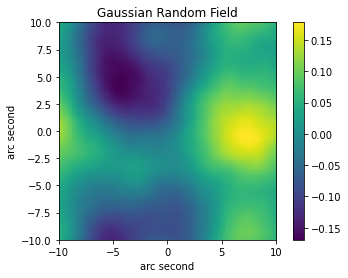

In [20]:
# Let's test the Gaussian Random Field generator code for some random parameters

#GRF parameters

var = random.choice(np.logspace(np.log10(1.000e-04), np.log10(1.000e-01), num=100))
pow = 6.0 
grpar = np.asarray([nx, ny, Lx, Ly, var, -pow])

gauss_rand = gauss_rand_2d (grpar) #GRF

print ("Variance:" , var)
print ("Power law exponent:" , -pow)


py.figure()
py.title('Gaussian Random Field')
py.xlabel('arc second')
py.ylabel('arc second')
py.imshow(gauss_rand, interpolation='nearest', extent=[-10,10, -10,10])
py.colorbar(fraction=0.046)
py.show()

### 6 - **Taking care of the point spread function (PSF) - Optional**

In [ ]:
f1 = pf.open('/content/drive/My Drive/PSFMODEL_KIDS.fits') #KiDS PSF 
                                                          # change the filename of the FITS file.

d1= f1[0].data
d1 = np.asarray(d1)

nx_ , ny_ = np.shape (d1)

psf = np.zeros ( ( nx , ny ) ) #output

dx = ( nx - nx_ ) / 2 #shift in x
dy = ( ny - ny_ ) / 2 #shift in y

for ii in xrange ( nx_ ): #iterating over input array
  for jj in xrange ( ny_ ):
    psf [ ii + dx ] [ jj + dy ] = d1 [ ii ] [ jj ]

### 7 - **Functions to define the Lens and Source parameters**

In [21]:
# -------------- Function to define the Lens plane parameters --------------

def lens_param (nx, ny, Lx, Ly, N):
 #-------- lens mass parameters -------------------------------
 b = 10**(np.random.uniform (np.log10(1.5), np.log10(5.0))) # Einstein Radius
 q_l = np.random.uniform(0.3, 0.99)                         # Axis ratio
 phi_l = np.random.uniform(0, 180)                          # major-minor axis angle
 ss = np.random.uniform(0, 0.05)                            # shear strength
 phi_ss = phi_l + np.random.uniform(0, 180)                 # shear angle

# --------- Lens parameter array -----------
 lpar = np.asarray([b, q_l, phi_l, ss, phi_ss]) #SIE parameters

 #------------- GRF parameters --------------------------------
 var = random.choice(np.logspace(np.log10(1.000e-04), np.log10(1.000e-01), num=N))
 pow = 6.0
 grpar = np.asarray ([nx, ny, Lx, Ly, var, -pow])
 return (lpar, grpar)

In [22]:
# -------------- Function to define the Source plane parameters --------------

def src_param (N_blob):

 #------------- main Sersic source parameters ------------------------
 i_eff = 1.0
 r_eff = 10**(np.random.uniform (np.log10(0.2), np.log10(0.6)))
 q_s = np.random.uniform(0.3, 0.99)
 phi_s = phi_l + np.random.uniform(0, 180)
 n = np.random.uniform(0.5, 5)
 (x_s, y_s) = src (q_l, b, r_eff, phi_l)
	
 serpar = np.asarray([i_eff, r_eff, x_s, y_s, q_s, phi_s, n]) #main sersic profile


 #-------- parameters for the blob sub-structures in the source ---------

 #------ common parameters of all the blobs
 i_eff_blob = 1.0  	# we keep the initial effective intensity of the profile to unity as 
										# it will be taken care of by the blob_amp_param

 q_s_blob = 0.999 	  # We keep the blobs circular
 phi_s_blob = 0.0   
	
 # we choose the centers of the blobs from a Gaussian PDF around the main blob.
 a = r_eff 	#sigma of this PDF is a function of the main effective radius
	
 # maximum flux ratio of the individual blobs. We choose a uniform random number between 0 and f_rat
 f_rat = 0.2
	
 #-------------------------------------------------------------

 blob_sersic_params = [] #list of Sersic parameters of the blobs
 blob_amp_param = [] #list of amplitudes of the blobs

 for b_n in range (N_blob+1):
	 #Sersic parameters of the blob structures
	 r_eff_blob = np.random.uniform(0.01, 0.1)*r_eff #effective radius of the first blob
	 n_blob = np.random.uniform(0.5, 5) #sersic index
	 x_s_blob = np.random.normal(x_s, a, 1) # the (x,y) positions of the blobs
	 y_s_blob = np.random.normal(y_s, a, 1)
	 a_blob = np.random.uniform(0, f_rat)
	
	 blob_sersic_params.append ([i_eff_blob, r_eff_blob, x_s_blob, y_s_blob, q_s_blob, phi_s_blob, n_blob])
	 blob_amp_param.append ([a_blob])

 blob = np.asarray(blob_sersic_params) #blob sersic profile parameters
 a_blob = np.asarray(blob_amp_param) #amplitudes

 return (serpar, blob, a_blob)

### 8 - **Simulation of strong gravitational lenses**

In [23]:
# Number of simulated galaxies. 
# How many mock lens candidates do you need? Change it accordingly..
N = 100

In [24]:
# delete previous contents of the directory
!rm -rf "/content/drive/My Drive/Strong_Lens_Simulation/"*

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/1/1.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


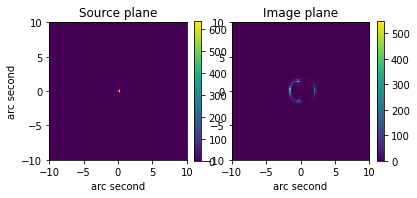

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/2/2.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


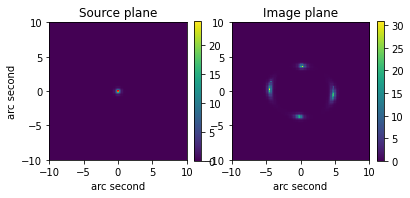

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/3/3.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


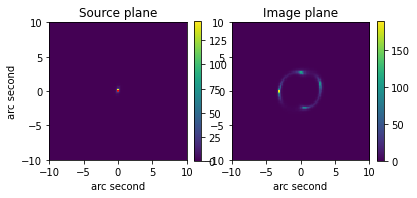

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/4/4.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


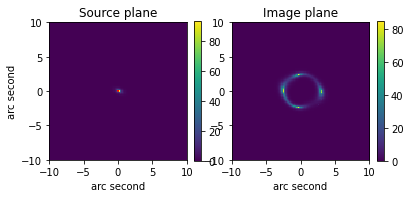

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/5/5.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


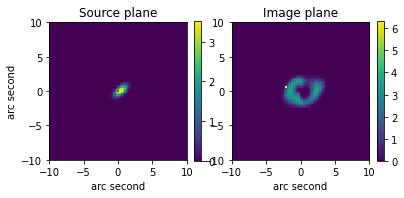

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/6/6.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


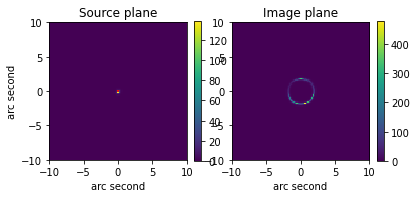

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/7/7.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


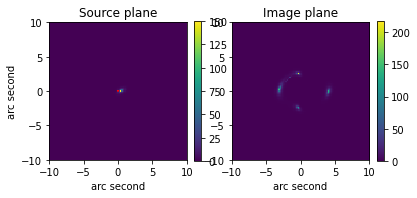

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/8/8.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


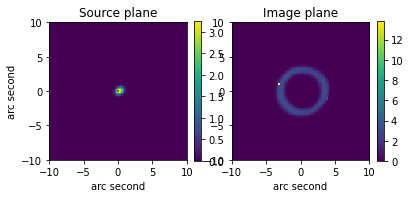

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/9/9.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


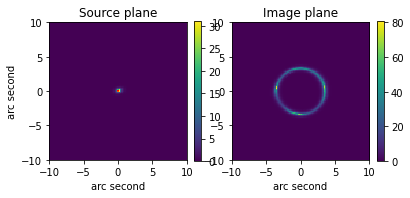

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/10/10.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


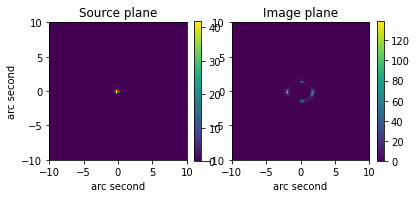

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/11/11.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


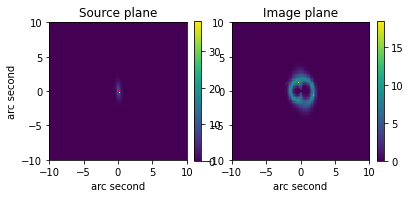

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/12/12.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


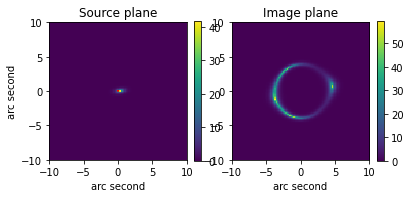

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/13/13.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


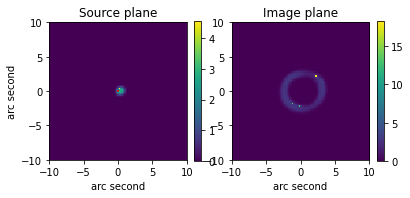

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/14/14.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


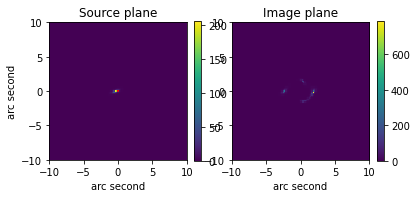

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/15/15.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


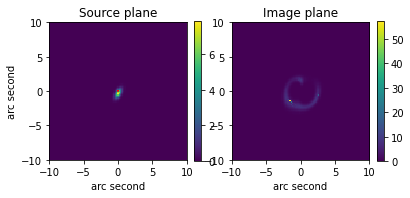

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/16/16.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


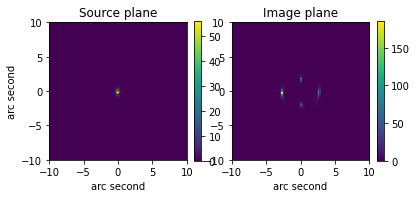

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/17/17.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


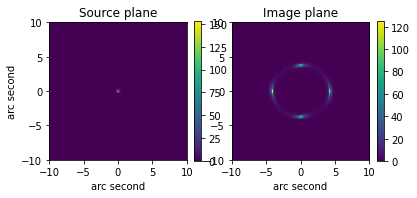

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/18/18.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


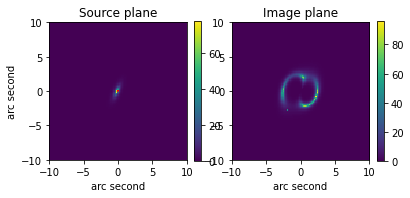

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/19/19.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


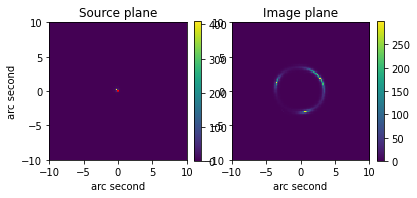

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/20/20.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


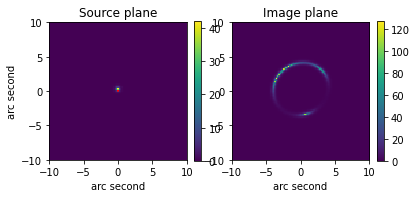

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/21/21.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


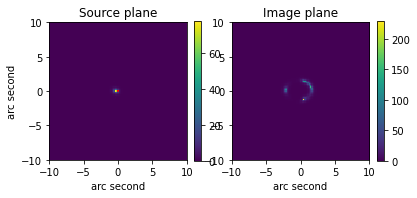

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/22/22.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


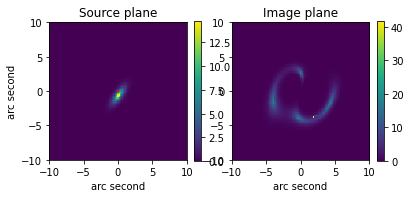

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/23/23.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


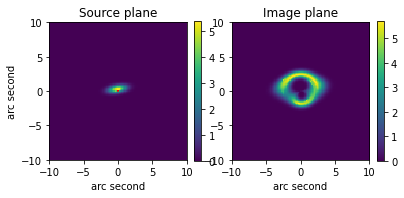

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/24/24.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


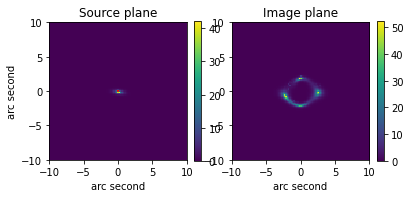

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/25/25.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


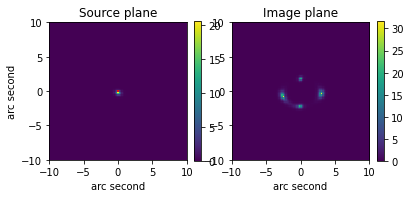

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/26/26.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


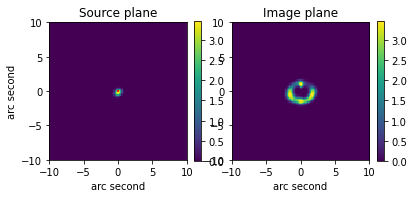

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/27/27.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


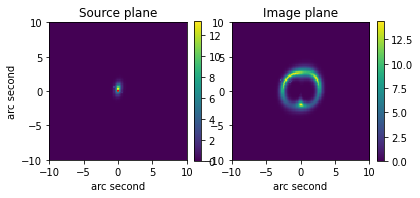

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/28/28.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


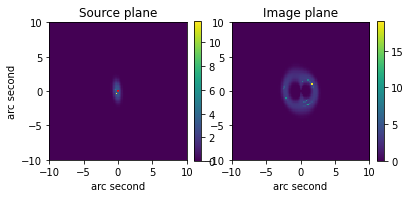

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/29/29.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


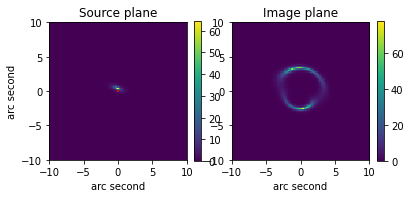

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/30/30.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


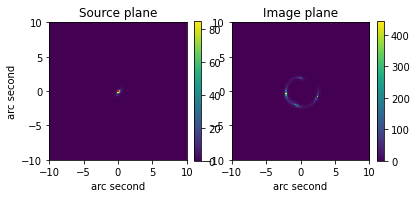

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/31/31.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


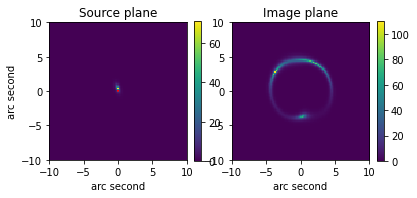

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/32/32.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


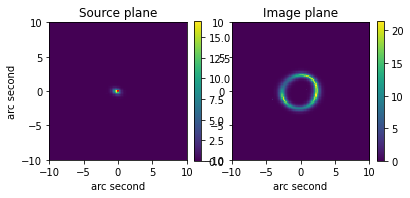

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/33/33.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


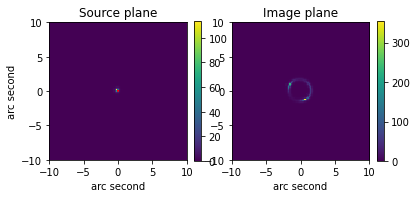

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/34/34.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


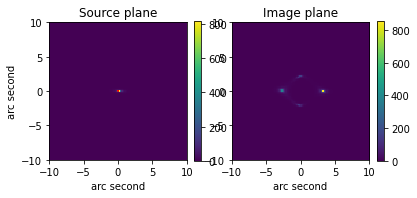

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/35/35.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


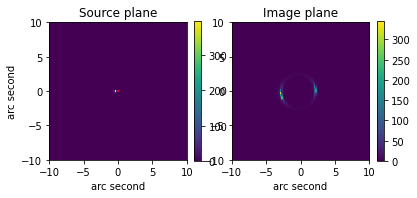

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/36/36.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


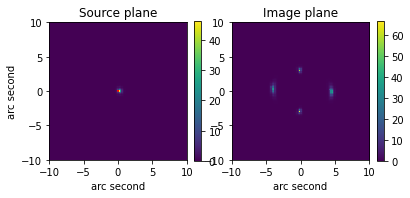

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/37/37.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


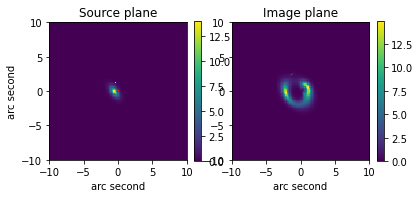

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/38/38.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


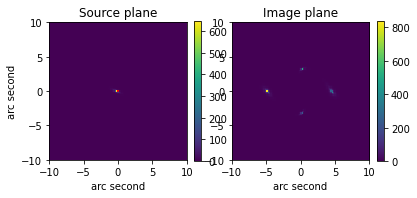

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/39/39.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


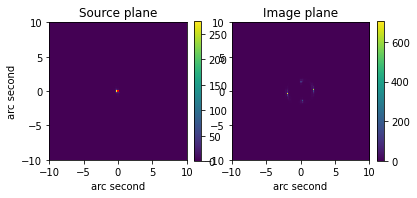

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/40/40.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


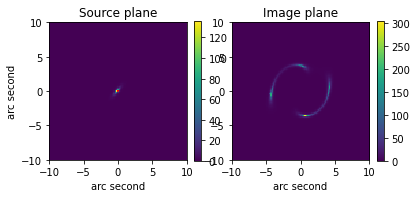

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/41/41.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


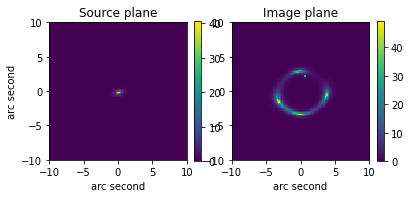

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/42/42.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


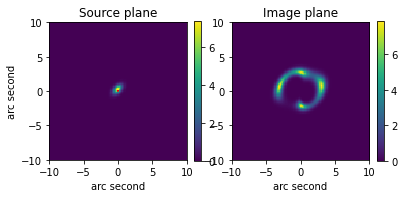

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/43/43.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


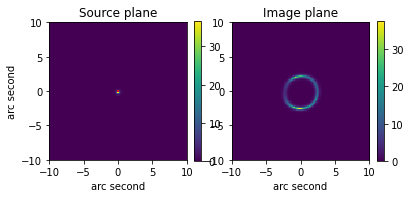

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/44/44.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


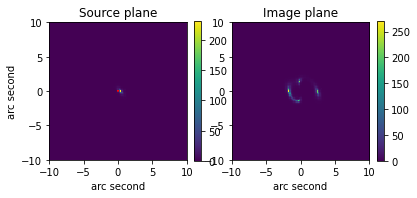

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/45/45.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


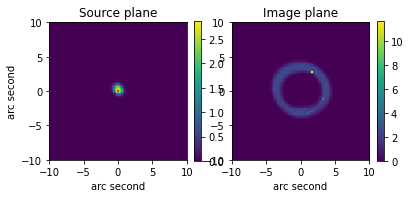

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/46/46.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


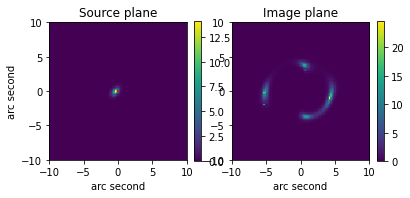

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/47/47.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


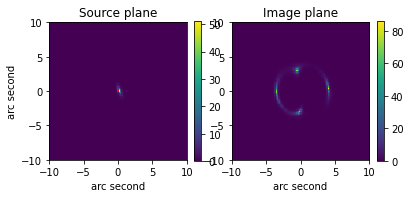

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/48/48.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


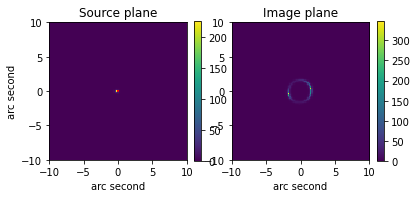

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/49/49.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


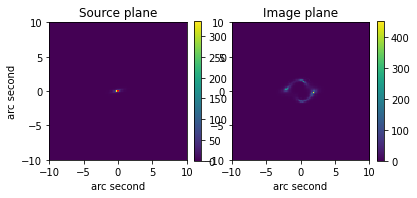

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/50/50.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


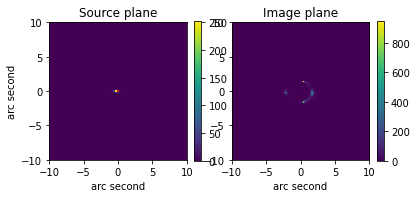

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/51/51.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


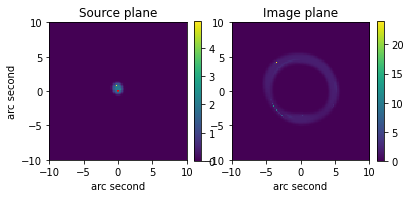

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/52/52.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


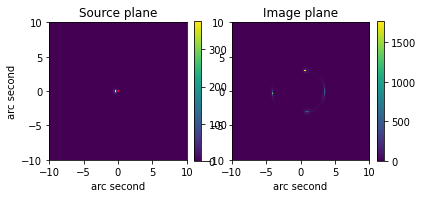

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/53/53.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


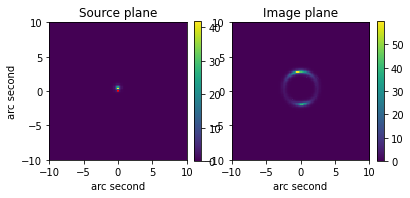

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/54/54.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


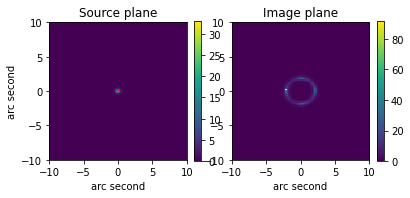

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/55/55.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


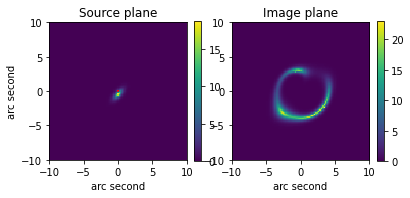

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/56/56.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


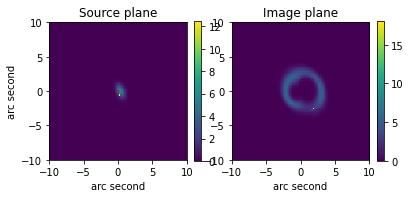

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/57/57.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


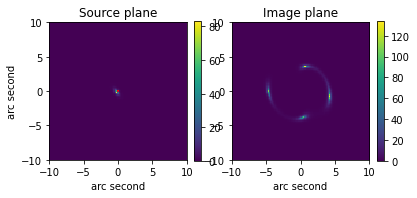

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/58/58.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


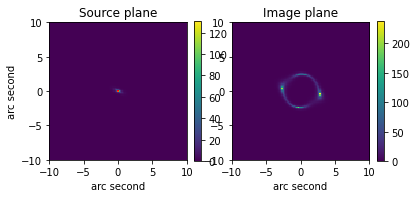

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/59/59.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


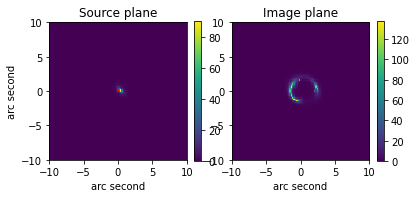

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/60/60.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


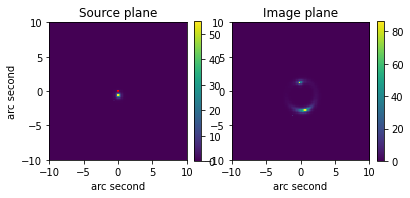

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/61/61.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


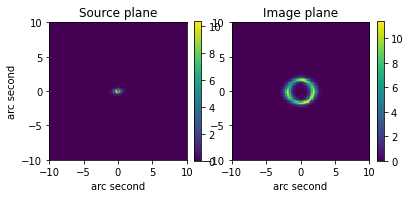

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/62/62.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


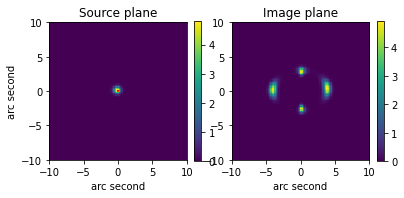

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/63/63.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


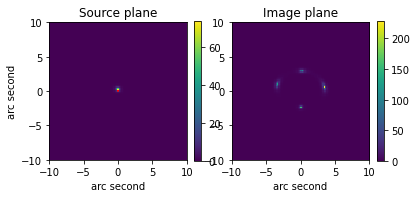

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/64/64.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


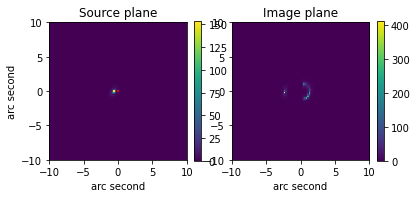

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/65/65.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


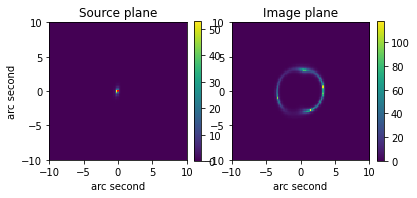

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/66/66.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


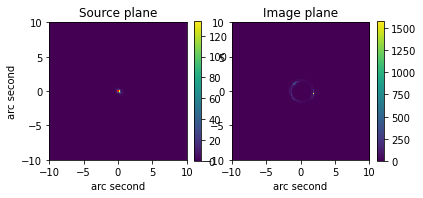

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/67/67.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


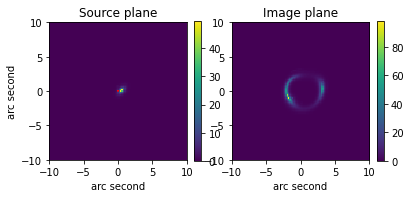

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/68/68.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


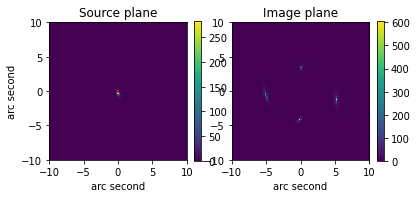

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/69/69.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


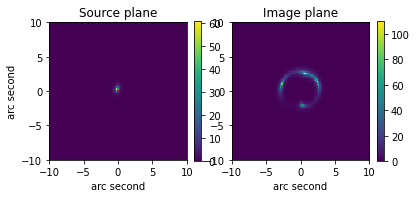

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/70/70.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


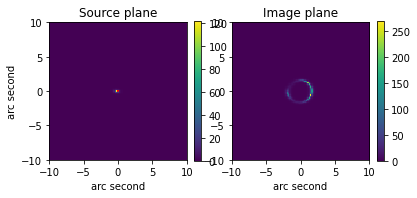

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/71/71.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


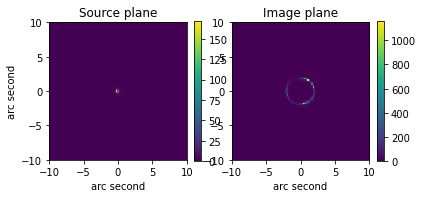

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/72/72.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


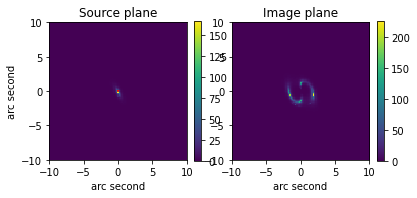

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/73/73.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


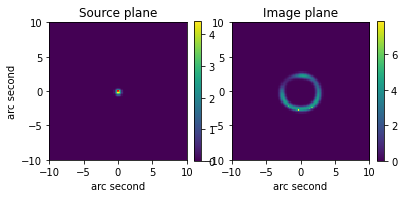

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/74/74.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


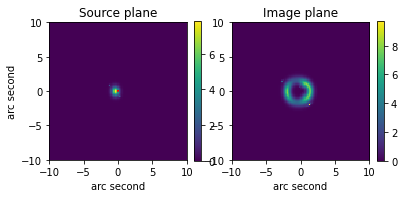

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/75/75.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


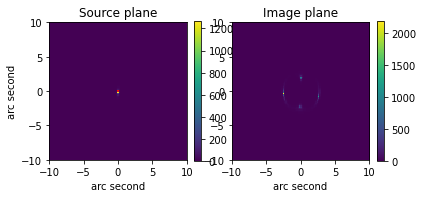

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/76/76.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


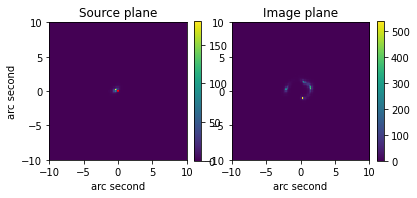

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/77/77.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


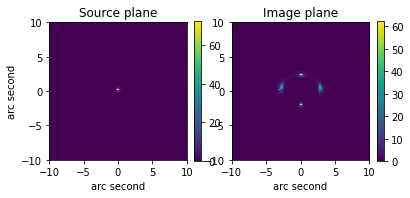

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/78/78.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


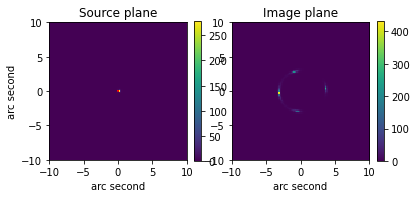

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/79/79.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


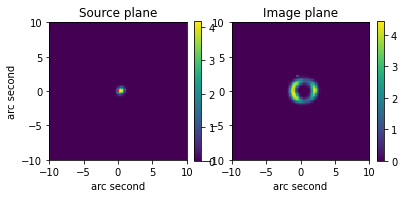

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/80/80.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


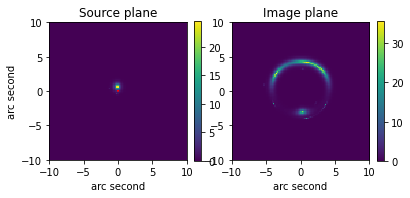

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/81/81.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


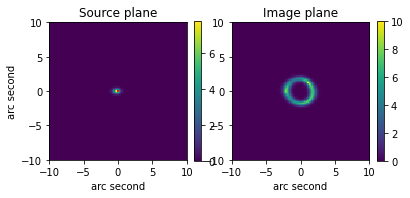

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/82/82.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


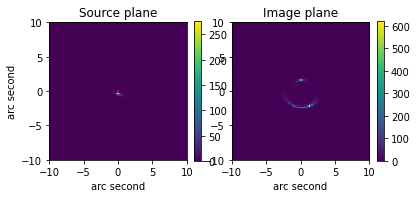

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/83/83.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


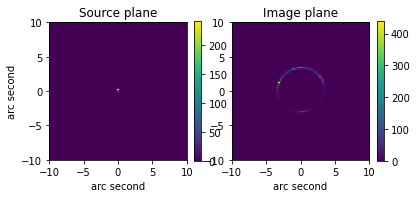

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/84/84.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


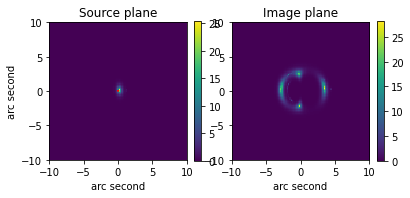

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/85/85.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


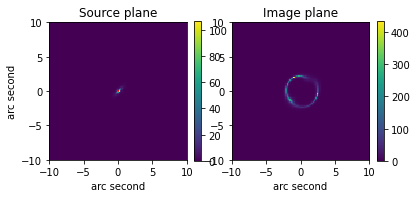

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/86/86.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


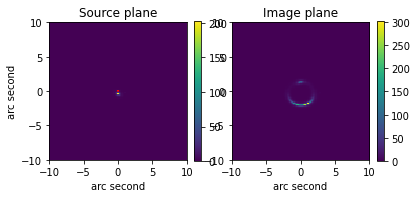

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/87/87.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


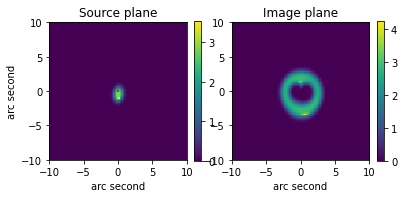

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/88/88.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


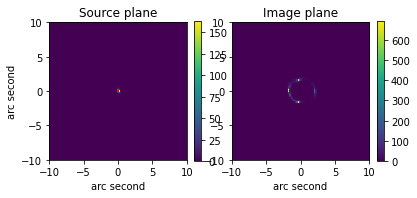

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/89/89.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


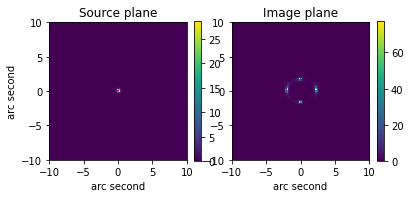

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/90/90.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


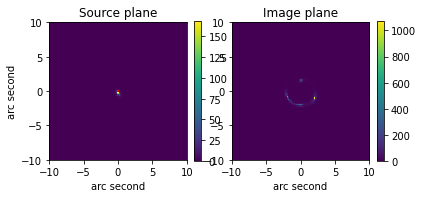

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/91/91.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


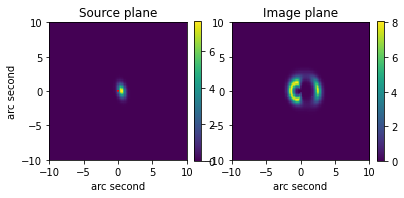

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/92/92.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


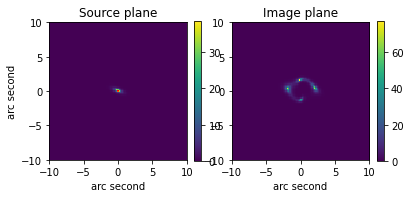

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/93/93.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


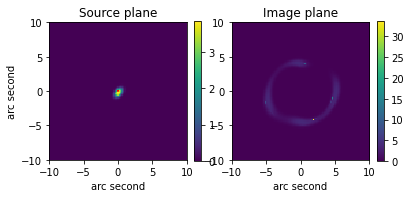

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/94/94.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


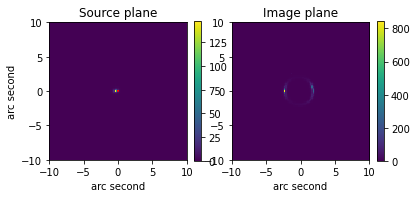

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/95/95.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


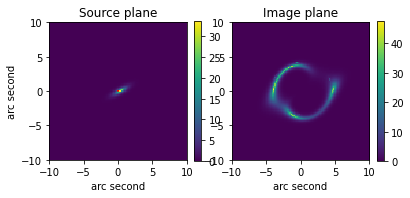

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/96/96.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


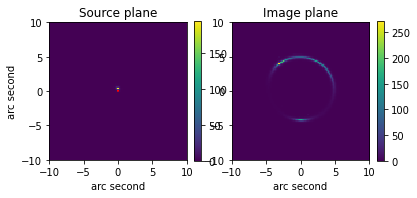

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/97/97.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


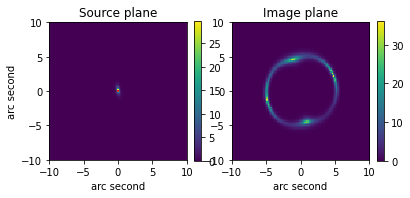

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/98/98.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


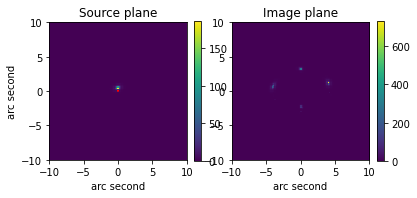

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/99/99.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


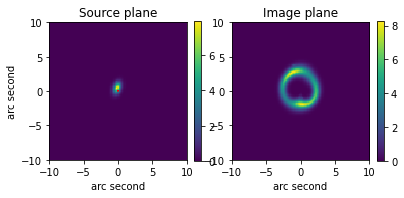

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/content/drive/My Drive/Strong_Lens_Simulation/100/100.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


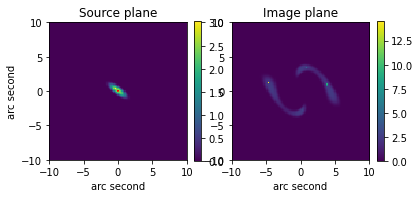

In [25]:
u = 1 # the initial id of the directory name to save the simulated lensed galaxy
 
# For loop that generates lensed galaxies
# Doesn't overwrite the existing files. 
# So, if you simulate same named files, please run the "rm -rf ..." command in the cell above.
 
for i in range(N):
    id = u
 
    (lpar, grpar) = lens_param (nx,ny, Lx, Ly, N)
 
    N_blob = np.random.randint (0, 5) #random number of blobs added with the main source (max. 5)
    (serpar, blob, a_blob) = src_param (N_blob)
    #-------------------------------------------------------------
    
    (xg, yg) = deflect_SIE(x, y, lpar) #The NIE gradient field
    gauss_rand = gauss_rand_2d (grpar)
    (x_r, y_r) = np.gradient (gauss_rand, grid_resolution, grid_resolution)
    source = sersic (x, y, serpar)
    image = sersic (x-xg-x_r, y-yg-y_r, serpar) #The lensed image using main Sersic + lens + GRF
 
    for jj in range(N_blob+1):
        source = source + a_blob[jj]*sersic(x, y, blob[jj])
        image = image + a_blob[jj]*sersic(x-xg-x_r, y-yg-y_r, blob[jj])
    
    #-------------------------------------------------------------------
 
    # In order to convolve with a PSF please uncomment the follwoing line
    #image = scipy.signal.fftconvolve (image, psf, mode = 'same') 
 
    #-------------------------------------------------------------------
 
    # If you want to normalise the image w.r.t. the maximum pixel value
    #image = image/image.max() 
 
    #-------------------------------------------------------------------
 
    path = os.path.join("/content/drive/My Drive/Strong_Lens_Simulation/", str(id))
    os.makedirs(path)
 
    pf.writeto(os.path.join(path, '%s.fits' %id), image) #write to a FITS file
    hu = pf.getheader(os.path.join(path,'%s.fits' %id)) # edit the FITS header
    hu['LENSER'] = lpar[0]
    hu['LENSAR'] = lpar[1]
    hu['LENSAA'] = lpar[2]
    hu['LENSSH'] = lpar[3]
    hu['LENSSA'] = lpar[4]
 
    hu['SRCER'] = serpar[1]
    hu['SRCX'] = serpar[2]
    hu['SRCY'] = serpar[3]
    hu['SRCAR'] = serpar[4]
    hu['SRCAA'] = serpar[5]
    hu['SRCSI'] = serpar[6]
 
 
    hu.comments['LENSER'] = 'Einstein radius of the lens in arc seconds'
    hu.comments['LENSAR'] = 'axis ratio of the lens potential'
    hu.comments['LENSAA'] = 'major-minor axis angle of the lens potential'
    hu.comments['LENSSH'] = 'external shear strength'
    hu.comments['LENSSA'] = 'external shear angle'
    
    hu.comments['SRCER'] = 'eff-radius of sersic profile in arc seconds'
    hu.comments['SRCX'] = 'x co-ordinate of source'
    hu.comments['SRCY'] = 'y co-ordinate of source'
    hu.comments['SRCAR'] = 'axis ratio of the source'
    hu.comments['SRCAA'] = 'major-minor axis angle of the source'
    hu.comments['SRCSI'] = 'sersic index of the source'
 
    pf.writeto(os.path.join(path, '%s.fits' %id), image, hu, clobber=True)
 
    u = u+1
 
    #-----------------------------------------------------------------------
 
    # Plots of the source and the simulated lensed galaxies
    py.figure()
    py.subplot(1,2,1)
    py.title('Source plane')
    py.xlabel('arc second')
    py.ylabel('arc second')
    py.imshow(source, interpolation='nearest', extent=[-10,10, -10,10])
    py.colorbar(fraction=0.046)
    py.plot(*caust_t(np.linspace(0, 2*np.pi, 200), q_l, b, phi_l), color='r', lw=1 )
 
    py.subplot(1,2,2)
    py.title('Image plane')
    py.xlabel('arc second')
    py.imshow(image, interpolation='nearest', extent=[-10,10, -10,10])
    py.colorbar(fraction=0.046)
    py.show()